In [30]:
%matplotlib inline
%load_ext autoreload
%autoreload 2
import matplotlib.pyplot as plt
import IPython.display
import numpy as np
from cued_sf2_lab.familiarisation import load_mat_img, plot_image
from cued_sf2_lab.jpeg import jpegdec, jpegenc
from scipy import optimize

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [31]:
lighthouse, _ = load_mat_img(img='lighthouse.mat', img_info='X')
bridge, _ = load_mat_img(img='bridge.mat', img_info='X')
flamingo, _ = load_mat_img(img='flamingo.mat', img_info='X')

lighthouse = lighthouse - 128.0
bridge = bridge - 128.0
flamingo = flamingo - 128.0

In [32]:
image = lighthouse # flamingo breaks variation of LBT and DWT
size_lim = 40906 - 1440 - 5

Raw


Size = 524288, Err = 0.0


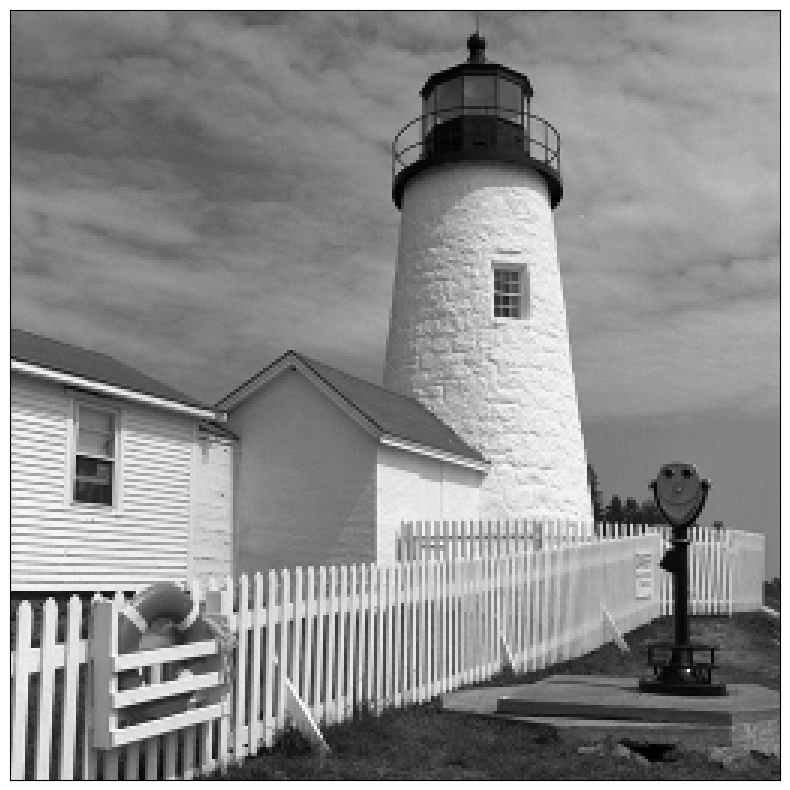

In [48]:
fig, ax = plt.subplots(figsize=(10, 10))
plot_image(image, ax=ax)
ax.set(yticks=[], xticks=[])

# fig.savefig("figs/l_raw.pdf")

print(f'Size = {256*256*8}, Err = {np.std(0):.4}')

In [34]:
pip install scikit-image



[notice] A new release of pip is available: 23.1.1 -> 23.1.2
[notice] To update, run: pip install --upgrade pip
Note: you may need to restart the kernel to use updated packages.


In [35]:
from skimage.metrics import structural_similarity as ssim
import numpy as np

def calculate_ssim(imageA: np.ndarray, imageB: np.ndarray) -> float:
    """
    Calculates Structural Similarity Index (SSIM) between two images.
    
    Parameters:
        imageA: Original image
        imageB: Image to compare
        
    Returns:
        ssim_index: SSIM index between two images
    """
    # The images should be in the same data range
    assert imageA.dtype == imageB.dtype, "Input images must have the same dtype."
    assert imageA.min() >= imageB.min() and imageA.max() <= imageB.max(), \
        "Input images must have the same data range."

    return ssim(imageA, imageB, data_range=imageB.max() - imageB.min())

In [36]:
%%script echo skipping

def error(qstep: int) -> int:

    Z, h = jpegenc(image, qstep, opthuff=True, dcbits=16, log=False)
    size = Z[:, 1].sum()
    return np.sum((size - size_lim)**2)

opt_step = optimize.minimize_scalar(error, method="bounded", bounds=(4, 128)).x
vlc, hufftab = jpegenc(image, opt_step, opthuff=True, dcbits=10, log=False)

Z = jpegdec(vlc, opt_step, hufftab=hufftab, dcbits=10, log=False)

fig, ax = plt.subplots(figsize=(20, 20))
plot_image(Z, ax=ax)
ax.set(yticks=[], xticks=[])

# fig.savefig("figs/l_jpeg_opthuff_dc16bits.pdf")


print(f'Size = {vlc[:, 1].sum()}, Step = {opt_step:.4} (check bounds), Err = {np.std(Z - image):.4}')

skipping


In [37]:
from compression import DWTCompression, LBTCompression


Size = 39423, Step = 31.2 (check bounds), Err = 9.152
SSIM:  0.8624220128008071


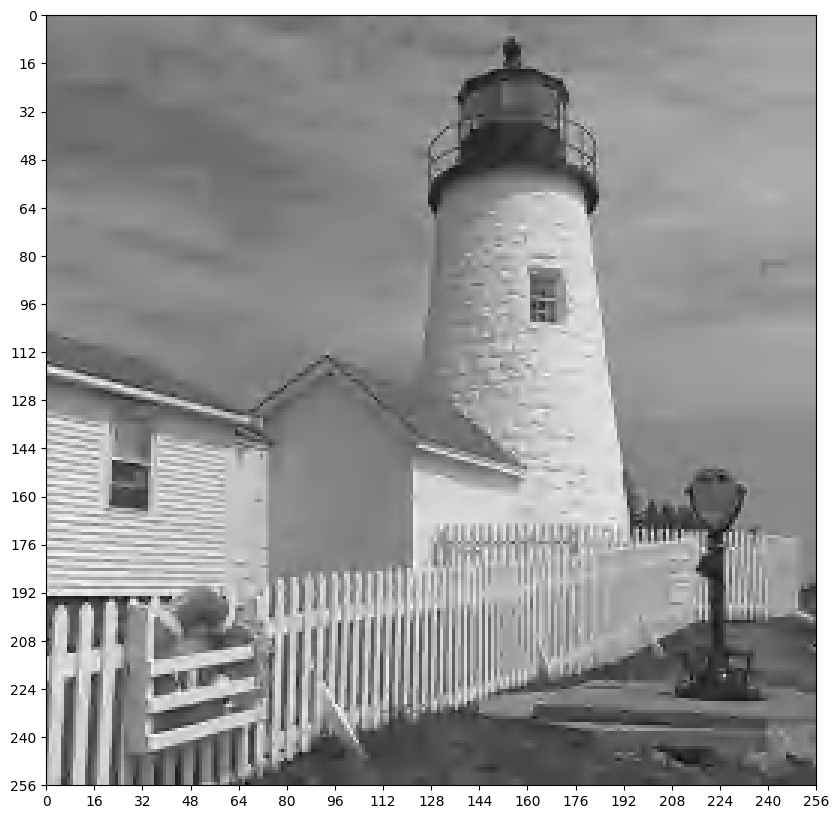

In [38]:
fig, ax = plt.subplots(figsize=(10, 10))
DWT = DWTCompression(5)
M = 16
Y1 = DWT.compress(image)

(vlc, hufftab), qs = DWT.opt_encode(Y1, size_lim=size_lim, M=M, root2=False)

Y = DWT.decode(vlc, qstep=qs, hufftab=hufftab, M=M, root2=False)

Z = DWT.decompress(Y)

plot_image(Z, ax=ax)
print(f'Size = {vlc[:, 1].sum()}, Step = {qs:.4} (check bounds), Err = {np.std(Z - image):.4}')

Z = Z.astype(image.dtype) #, the astype function is used to change the data type of Z to match the data type of image
ssim_index = calculate_ssim( image , Z)
print("SSIM: ", ssim_index)

Size = 39465, Step = 2.13 (check bounds), Err = 9.212
SSIM:  0.8838038504436982


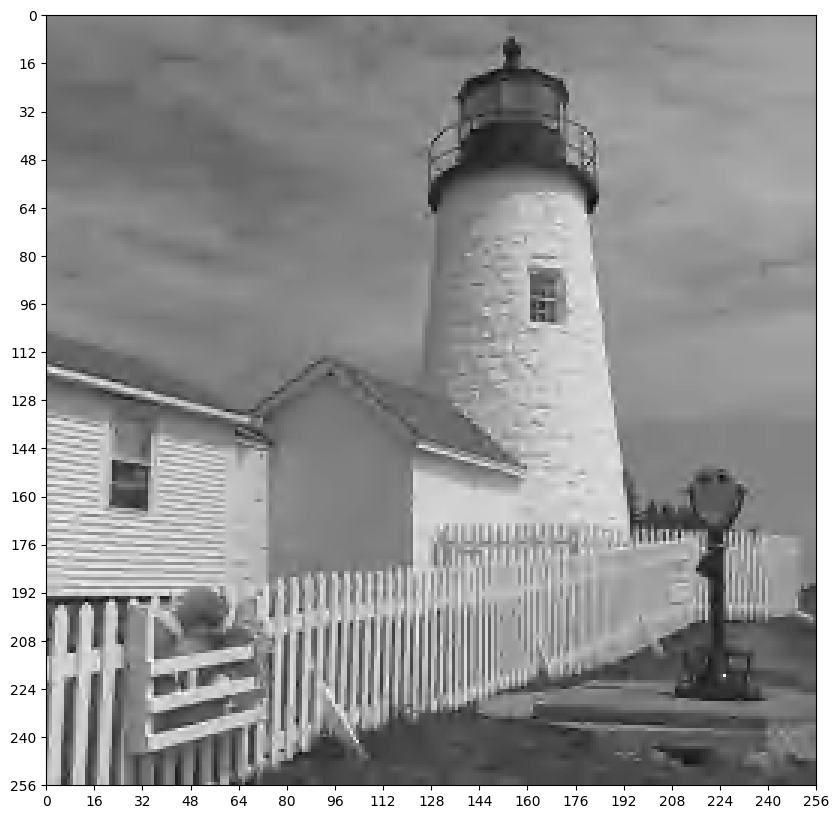

In [39]:
fig, ax = plt.subplots(figsize=(10, 10))

DWT = DWTCompression(4) # 5 layers breaks saying code size is too big

Y = DWT.compress(image)

(vlc, hufftab), qs = DWT.opt_encode(Y, size_lim=size_lim, M=16, rise_ratio=0.5)

Y = DWT.decode(vlc, qstep=qs, hufftab=hufftab, M=16, rise_ratio=0.5)

Z = DWT.decompress(Y)

plot_image(Z, ax=ax)
print(f'Size = {vlc[:, 1].sum()}, Step = {qs:.4} (check bounds), Err = {np.std(Z - image):.4}')
#print(type(Z))
#print(type(image))
#print(Z.size)
#print(image.size)
Z = Z.astype(image.dtype) #, the astype function is used to change the data type of Z to match the data type of image
ssim_index = calculate_ssim( image , Z)
print("SSIM: ", ssim_index)
#ax.set(yticks=[], xticks=[]) 



Size = 39463, Step = 1.688 (check bounds), Err = 8.918
SSIM:  0.8749350751810487


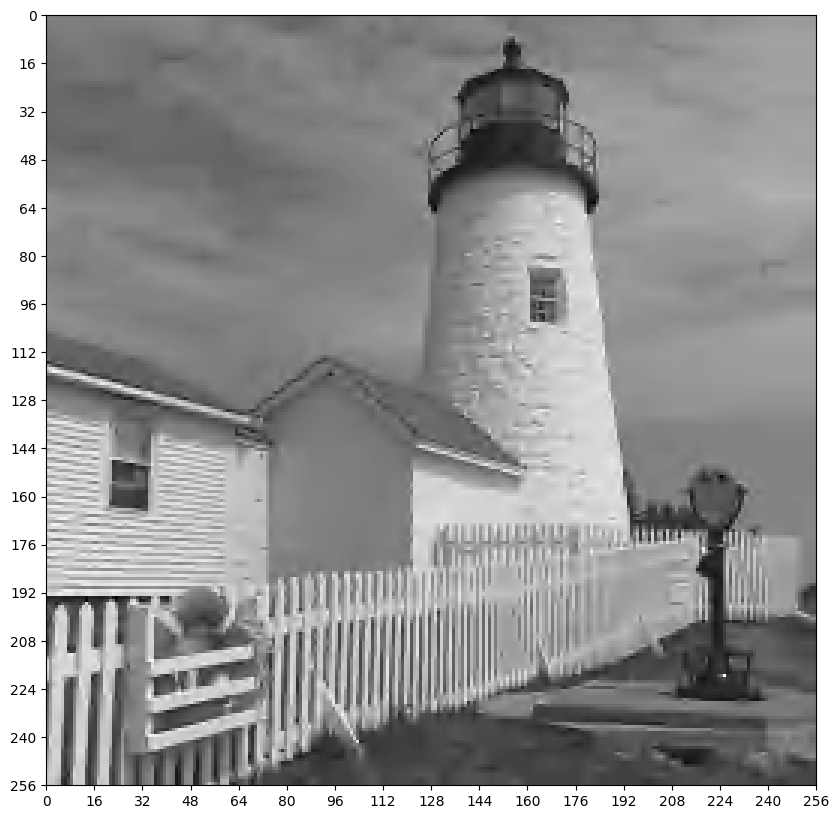

In [40]:
fig, ax = plt.subplots(figsize=(10, 10))

DWT = DWTCompression(4)
RR = 0.68
M = 16

Y = DWT.compress(image)

(vlc, hufftab), qs = DWT.opt_encode(Y, size_lim=size_lim, M=M, rise_ratio=RR)

Y = DWT.decode(vlc, qstep=qs, hufftab=hufftab, M=M, rise_ratio=RR)

Z = DWT.decompress(Y)

plot_image(Z, ax=ax)
print(f'Size = {vlc[:, 1].sum()}, Step = {qs:.4} (check bounds), Err = {np.std(Z - image):.4}')
Z = Z.astype(image.dtype) #, the astype function is used to change the data type of Z to match the data type of image
ssim_index = calculate_ssim( image , Z)
print("SSIM: ", ssim_index)


**LBT**

Size = 39460, Step = 32.39 (check bounds), Err = 8.079
SSIM:  0.8812638452174432


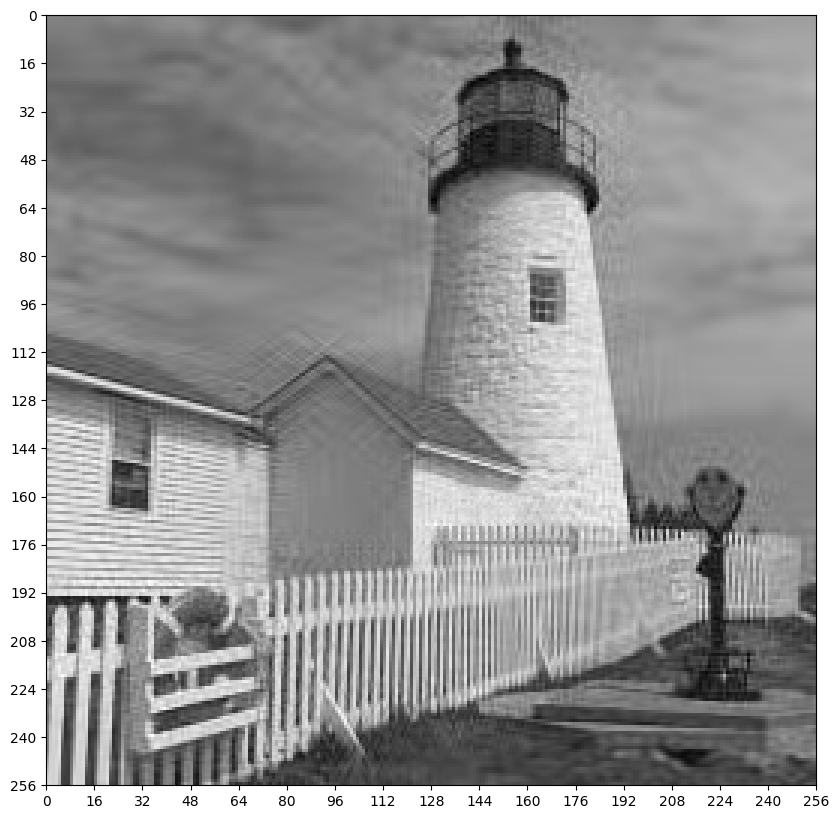

In [41]:
M = 16

scheme = LBTCompression(s=1.3, N=M)

fig, ax = plt.subplots(figsize=(10, 10))

Y = scheme.compress(image)
(vlc, hufftab), qs = scheme.opt_encode(Y, size_lim=size_lim, M=M)
header = (hufftab, qs)

Y = scheme.decode(vlc, qstep=header[1], M=M, hufftab=header[0])
Z = scheme.decompress(Y)

plot_image(Z, ax=ax)
print(f'Size = {vlc[:, 1].sum()}, Step = {qs:.4} (check bounds), Err = {np.std(Z - image):.4}')

Z = Z.astype(image.dtype) #, the astype function is used to change the data type of Z to match the data type of image
ssim_index = calculate_ssim( image , Z)
print("SSIM: ", ssim_index)

Size = 39461, Step = 1.166 (check bounds), Err = 8.329
SSIM:  0.8812638452174432


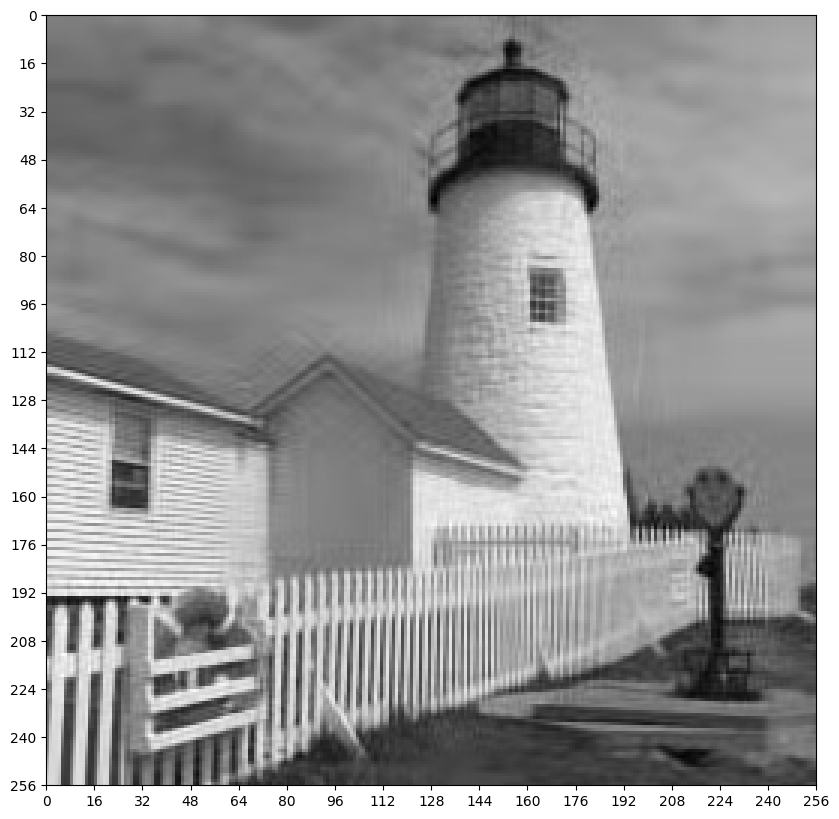

In [42]:
M = 16

scheme = LBTCompression(s=1.3, N=M)

fig, ax = plt.subplots(figsize=(10, 10))

Y = scheme.compress(image)
(vlc, hufftab), qs = scheme.opt_encode(Y, size_lim=size_lim, M=M, quant_grad=True)
header = (hufftab, np.float16(qs))

Y = scheme.decode(vlc, qstep=header[1], M=M, hufftab=header[0], quant_grad=True)
Za = scheme.decompress(Y)
plot_image(Za, ax=ax)
print(f'Size = {vlc[:, 1].sum()}, Step = {qs:.4} (check bounds), Err = {np.std(Za - image):.4}')

Z = Z.astype(image.dtype) #, the astype function is used to change the data type of Z to match the data type of image
ssim_index = calculate_ssim( image , Z)
print("SSIM: ", ssim_index)

Size = 39461, Step = 1.166 (check bounds), Err = 8.329
SSIM:  0.8749967008413758


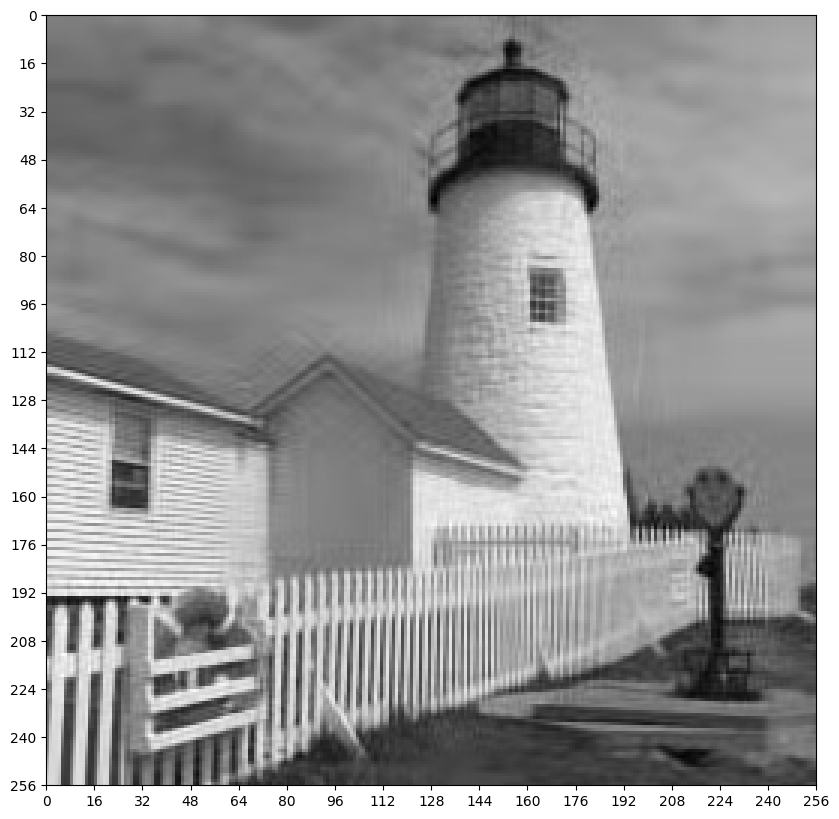

In [45]:
M = 16

scheme = LBTCompression(s=1.3, N=M)

fig, ax = plt.subplots(figsize=(10, 10))

Y = scheme.compress(image)
(vlc, hufftab), qs = scheme.opt_encode(Y, size_lim=size_lim, M=M, quant_grad=True)
header = (hufftab, np.float16(qs))

Y = scheme.decode(vlc, qstep=header[1], M=M, hufftab=header[0], quant_grad=True)
Z = scheme.decompress(Y)
plot_image(Z, ax=ax)
print(f'Size = {vlc[:, 1].sum()}, Step = {qs:.4} (check bounds), Err = {np.std(Z - image):.4}')

Z = Z.astype(image.dtype) #, the astype function is used to change the data type of Z to match the data type of image
ssim_index = calculate_ssim( image , Z)
print("SSIM: ", ssim_index)